# Watershed Distance Transform for 3D Data
---
Implementation of papers:

[Deep Watershed Transform for Instance Segmentation](http://openaccess.thecvf.com/content_cvpr_2017/papers/Bai_Deep_Watershed_Transform_CVPR_2017_paper.pdf)

[Learn to segment single cells with deep distance estimator and deep cell detector](https://arxiv.org/abs/1803.10829)

In [1]:
import os
import errno
import datetime

import numpy as np

import deepcell

## Load the data

### Download the data from `deepcell.datasets`

`deepcell.datasets` provides access to a set of annotated live-cell imaging datasets which can be used for training cell segmentation and tracking models.
All dataset objects share the `load_data()` method, which allows the user to specify the name of the file (`path`), the fraction of data reserved for testing (`test_size`) and a `seed` which is used to generate the random train-test split.
Metadata associated with the dataset can be accessed through the `metadata` attribute.

In [2]:
# Download the data (saves to ~/.keras/datasets)
filename = 'mousebrain.npz'
test_size = 0.1 # % of data saved as test
seed = 0 # seed for random train-test split

(X_train, y_train), (X_test, y_test) = deepcell.datasets.mousebrain.load_data(filename, test_size=test_size, seed=seed)

print('X.shape: {}\ny.shape: {}'.format(X_train.shape, y_train.shape))

1730158592/1730150850 [==============================] - 72s 0us/step
X.shape: (198, 15, 256, 256, 1)
y.shape: (198, 15, 256, 256, 1)


### Set up filepath constants

In [3]:
# the path to the data file is currently required for `train_model_()` functions

# change DATA_DIR if you are not using `deepcell.datasets`
DATA_DIR = os.path.expanduser(os.path.join('~', '.keras', 'datasets'))

# DATA_FILE should be a npz file, preferably from `make_training_data`
DATA_FILE = os.path.join(DATA_DIR, filename)

# confirm the data file is available
assert os.path.isfile(DATA_FILE)

In [4]:
# Set up other required filepaths

# If the data file is in a subdirectory, mirror it in MODEL_DIR and LOG_DIR
PREFIX = os.path.relpath(os.path.dirname(DATA_FILE), DATA_DIR)

ROOT_DIR = '/data'  # TODO: Change this! Usually a mounted volume
MODEL_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'models', PREFIX))
LOG_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'logs', PREFIX))

# create directories if they do not exist
for d in (MODEL_DIR, LOG_DIR):
    try:
        os.makedirs(d)
    except OSError as exc:  # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise

## Create the Foreground/Background FeatureNet Model

Here we instantiate two `FeatureNet` models from `deepcell.model_zoo` for foreground/background separation as well as the interior/edge segmentation.

In [5]:
frames_per_batch = 3
norm_method = 'whole_image'  # data normalization - `whole_image` for 3d conv
receptive_field = 61  # should be adjusted for the scale of the data
n_skips = 1  # number of skip-connections (only for FC training)

In [6]:
# watershed transform settings
distance_bins = 4
erosion_width = 1  # erode edges, improves segmentation when cells are close
watershed_kwargs = {
    'distance_bins': distance_bins,
    'erosion_width': erosion_width,
}

In [7]:
from deepcell import model_zoo

fgbg_model = model_zoo.bn_feature_net_skip_3D(
    receptive_field=receptive_field,
    n_features=2,  # segmentation mask (is_cell, is_not_cell)
    n_frames=frames_per_batch,
    n_skips=n_skips,
    n_conv_filters=32,
    n_dense_filters=128,
    input_shape=tuple([frames_per_batch] + list(X_train.shape[2:])),
    multires=False,
    last_only=False,
    norm_method=norm_method)

## Prepare for training

### Set up training parameters.

There are a number of tunable hyper parameters necessary for training deep learning models:

**model_name**: Incorporated into any files generated during the training process.

**n_epoch**: The number of complete passes through the training dataset.

**lr**: The learning rate determines the speed at which the model learns. Specifically it controls the relative size of the updates to model values after each batch.

**optimizer**: The TensorFlow module [tf.keras.optimizers](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) offers optimizers with a variety of algorithm implementations. DeepCell typically uses the Adam or the SGD optimizers.

**lr_sched**: A learning rate scheduler allows the learning rate to adapt over the course of model training. Typically a larger learning rate is preferred during the start of the training process, while a small learning rate allows for fine-tuning during the end of training.

**batch_size**: The batch size determines the number of samples that are processed before the model is updated. The value must be greater than one and less than or equal to the number of samples in the training dataset.

In [8]:
from tensorflow.keras.optimizers import SGD
from deepcell.utils.train_utils import rate_scheduler

fgbg_model_name = 'conv_fgbg_3d_model'
watershed_model_name = 'conv_watershed_3d_model'

n_epoch = 5  # Number of training epochs

fgbg_optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
watershed_optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

lr_sched = rate_scheduler(lr=0.01, decay=0.99)

batch_size = 1  # FC training uses 1 image per batch

### Create the DataGenerators

The `MovieDataGenerator` outputs a raw image sequence (`X`) with it's labeled annotation mask (`y`). Additionally, it can apply a transform to `y` to change the task the model learns. Below we generate 2 training and validation data sets for both the foreground/background model and the pixelwise model.

In [9]:
from deepcell.image_generators import MovieDataGenerator

datagen = MovieDataGenerator(
    rotation_range=180,
    zoom_range=(.8, 1.2),
    horizontal_flip=True,
    vertical_flip=True)

datagen_val = MovieDataGenerator()

In [10]:
# Create the foreground/background data iterators

fgbg_train_data = datagen.flow(
    {'X': X_train, 'y': y_train},
    skip=n_skips,
    seed=seed,
    batch_size=batch_size,
    transform='fgbg',
    frames_per_batch=frames_per_batch)

fgbg_val_data = datagen_val.flow(
    {'X': X_test, 'y': y_test},
    skip=n_skips,
    seed=seed,
    batch_size=batch_size,
    transform='fgbg',
    frames_per_batch=frames_per_batch)

In [11]:
# Create the pixelwise data iterators

watershed_train_data = datagen.flow(
    {'X': X_train, 'y': y_train},
    skip=n_skips,
    seed=seed,
    batch_size=batch_size,
    transform='watershed',
    transform_kwargs=watershed_kwargs,
    frames_per_batch=frames_per_batch)

watershed_val_data = datagen_val.flow(
    {'X': X_test, 'y': y_test},
    skip=n_skips,
    seed=seed,
    batch_size=batch_size,
    transform='watershed',
    transform_kwargs=watershed_kwargs,
    frames_per_batch=frames_per_batch)

Visualize the data generator output.

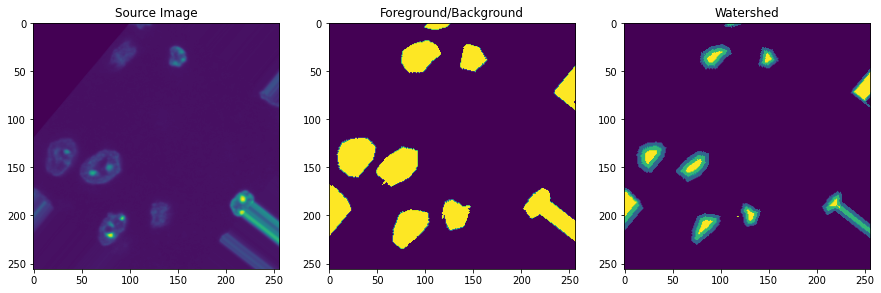

In [12]:
from matplotlib import pyplot as plt

# Different data generators but same data and same seed
img, fgbg_output = fgbg_train_data.next()
_, watershed_output = watershed_train_data.next()

frame = np.random.randint(0, frames_per_batch)

if n_skips:
    fgbg_output = fgbg_output[0]
    watershed_output = watershed_output[0]

fig, axes = plt.subplots(1, 3, figsize=(15, 15))
ax = axes.ravel()

ax[0].imshow(img[0, frame, ..., 0])
ax[0].set_title('Source Image')

ax[1].imshow(np.argmax(fgbg_output[0, frame, ...], axis=-1))
ax[1].set_title('Foreground/Background')

ax[2].imshow(np.argmax(watershed_output[0, frame, ...], axis=-1))
ax[2].set_title('Watershed')

plt.show()

### Compile the model with a loss function

Each model is trained with it's own loss function. `weighted_categorical_crossentropy` is often used for classification models, but `weighted_focal_loss` is also supported. The losses are passed to `model.compile` before training.

In [13]:
from deepcell import losses

def loss_function(y_true, y_pred):
    return losses.weighted_categorical_crossentropy(
        y_true, y_pred,
        n_classes=2,
        from_logits=False)

fgbg_model.compile(
    loss=loss_function,
    optimizer=fgbg_optimizer,
    metrics=['accuracy'])

## Train the foreground/background model

Call `fit()` on the compiled model, along with a default set of callbacks.

In [14]:
from deepcell.utils.train_utils import get_callbacks
from deepcell.utils.train_utils import count_gpus

model_path = os.path.join(MODEL_DIR, '{}.h5'.format(fgbg_model_name))
loss_path = os.path.join(MODEL_DIR, '{}.npz'.format(fgbg_model_name))

num_gpus = count_gpus()

print('Training on', num_gpus, 'GPUs.')

train_callbacks = get_callbacks(
    model_path,
    lr_sched=lr_sched,
    save_weights_only=num_gpus >= 2,
    monitor='val_loss',
    verbose=1)

loss_history = fgbg_model.fit(
    fgbg_train_data,
    steps_per_epoch=fgbg_train_data.y.shape[0] // batch_size,
    epochs=n_epoch,
    validation_data=fgbg_val_data,
    validation_steps=fgbg_val_data.y.shape[0] // batch_size,
    callbacks=train_callbacks)

Training on 1 GPUs.
Epoch 1/5
198/198 [==============================] - ETA: 0s - loss: 0.5090 - functional_1_loss: 0.2445 - functional_3_loss: 0.2413 - functional_1_accuracy: 0.8980 - functional_3_accuracy: 0.9002
Epoch 00001: val_loss improved from inf to 0.40859, saving model to /data/models/conv_fgbg_3d_model.h5
198/198 [==============================] - 50s 255ms/step - loss: 0.5090 - functional_1_loss: 0.2445 - functional_3_loss: 0.2413 - functional_1_accuracy: 0.8980 - functional_3_accuracy: 0.9002 - val_loss: 0.4086 - val_functional_1_loss: 0.1887 - val_functional_3_loss: 0.1967 - val_functional_1_accuracy: 0.9255 - val_functional_3_accuracy: 0.9187
Epoch 2/5
198/198 [==============================] - ETA: 0s - loss: 0.4209 - functional_1_loss: 0.1987 - functional_3_loss: 0.1990 - functional_1_accuracy: 0.9192 - functional_3_accuracy: 0.9182
Epoch 00002: val_loss improved from 0.40859 to 0.37172, saving model to /data/models/conv_fgbg_3d_model.h5
198/198 [=====================

## Create the `watershed` FeatureNet Model

Here we instantiate two `FeatureNet` models from `deepcell.model_zoo` for foreground/background separation as well as the interior/edge segmentation.

In [15]:
from deepcell import model_zoo

watershed_model = model_zoo.bn_feature_net_skip_3D(
    fgbg_model=fgbg_model,
    receptive_field=receptive_field,
    n_skips=n_skips,
    n_features=distance_bins,
    n_frames=frames_per_batch,
    n_conv_filters=32,
    n_dense_filters=128,
    multires=False,
    last_only=False,
    input_shape=tuple([frames_per_batch] + list(X_train.shape[2:])),
    norm_method=norm_method)

### Compile the model with a loss function

Just like the foreground/background model, the `watershed` model is compiled with the `weighted_categorical_crossentropy` loss function.

In [16]:
from deepcell import losses

def loss_function(y_true, y_pred):
    return losses.weighted_categorical_crossentropy(
        y_true, y_pred,
        n_classes=distance_bins,
        from_logits=False)

watershed_model.compile(
    loss=loss_function,
    optimizer=watershed_optimizer,
    metrics=['accuracy'])

## Train the `watershed` model

Call `fit()` on the compiled model, along with a default set of callbacks.

In [17]:
from deepcell.utils.train_utils import get_callbacks
from deepcell.utils.train_utils import count_gpus

model_path = os.path.join(MODEL_DIR, '{}.h5'.format(watershed_model_name))
loss_path = os.path.join(MODEL_DIR, '{}.npz'.format(watershed_model_name))

num_gpus = count_gpus()

print('Training on', num_gpus, 'GPUs.')

train_callbacks = get_callbacks(
    model_path,
    lr_sched=lr_sched,
    save_weights_only=num_gpus >= 2,
    monitor='val_loss',
    verbose=1)

loss_history = watershed_model.fit(
    watershed_train_data,
    steps_per_epoch=watershed_train_data.y.shape[0] // batch_size,
    epochs=n_epoch,
    validation_data=watershed_val_data,
    validation_steps=watershed_val_data.y.shape[0] // batch_size,
    callbacks=train_callbacks)

Training on 1 GPUs.
Epoch 1/5
198/198 [==============================] - ETA: 0s - loss: 1.9603 - functional_7_loss: 0.9426 - functional_9_loss: 0.9713 - functional_7_accuracy: 0.8321 - functional_9_accuracy: 0.8255
Epoch 00001: val_loss improved from inf to 1.78378, saving model to /data/models/conv_watershed_3d_model.h5
198/198 [==============================] - 65s 330ms/step - loss: 1.9603 - functional_7_loss: 0.9426 - functional_9_loss: 0.9713 - functional_7_accuracy: 0.8321 - functional_9_accuracy: 0.8255 - val_loss: 1.7838 - val_functional_7_loss: 0.8676 - val_functional_9_loss: 0.8698 - val_functional_7_accuracy: 0.8624 - val_functional_9_accuracy: 0.8773
Epoch 2/5
198/198 [==============================] - ETA: 0s - loss: 1.7134 - functional_7_loss: 0.8365 - functional_9_loss: 0.8305 - functional_7_accuracy: 0.8834 - functional_9_accuracy: 0.8830
Epoch 00002: val_loss improved from 1.78378 to 1.65428, saving model to /data/models/conv_watershed_3d_model.h5
198/198 [===========

## Predict on test data

Use the trained model to predict on new data and post-process the results into a label mask.

In [18]:
# too many batches at once causes OOM
X_test, y_test = X_test[:4], y_test[:4]
print(X_test.shape)

(4, 15, 256, 256, 1)


In [19]:
test_images = watershed_model.predict(X_test)[-1]
test_images_fgbg = fgbg_model.predict(X_test)[-1]

print('watershed transform shape:', test_images.shape)
print('segmentation mask shape:', test_images_fgbg.shape)

watershed transform shape: (4, 15, 256, 256, 4)
segmentation mask shape: (4, 15, 256, 256, 2)


#### Watershed post-processing

In [20]:
argmax_images = []
for i in range(test_images.shape[0]):
    max_image = np.argmax(test_images[i], axis=-1)
    argmax_images.append(max_image)
argmax_images = np.array(argmax_images)
argmax_images = np.expand_dims(argmax_images, axis=-1)

print('watershed argmax shape:', argmax_images.shape)

watershed argmax shape: (4, 15, 256, 256, 1)


In [21]:
# threshold the foreground/background
# and remove back ground from watershed transform
threshold = 0.5

fg_thresh = test_images_fgbg[..., 1] > threshold
fg_thresh = np.expand_dims(fg_thresh, axis=-1)

argmax_images_post_fgbg = argmax_images * fg_thresh

In [22]:
# Apply watershed method with the distance transform as seed
from skimage.measure import label
from skimage.morphology import watershed
from skimage.feature import peak_local_max

watershed_images = []
for i in range(argmax_images_post_fgbg.shape[0]):
    image = fg_thresh[i, ..., 0]
    distance = argmax_images_post_fgbg[i, ..., 0]

    local_maxi = peak_local_max(
        test_images[i, ..., -1],
        min_distance=10,
        threshold_abs=0.05,
        indices=False,
        labels=image,
        exclude_border=False)

    markers = label(local_maxi)
    segments = watershed(-distance, markers, mask=image)
    watershed_images.append(segments)

watershed_images = np.array(watershed_images)
watershed_images = np.expand_dims(watershed_images, axis=-1)

### Plot the results

Image: 2
Frame: 9


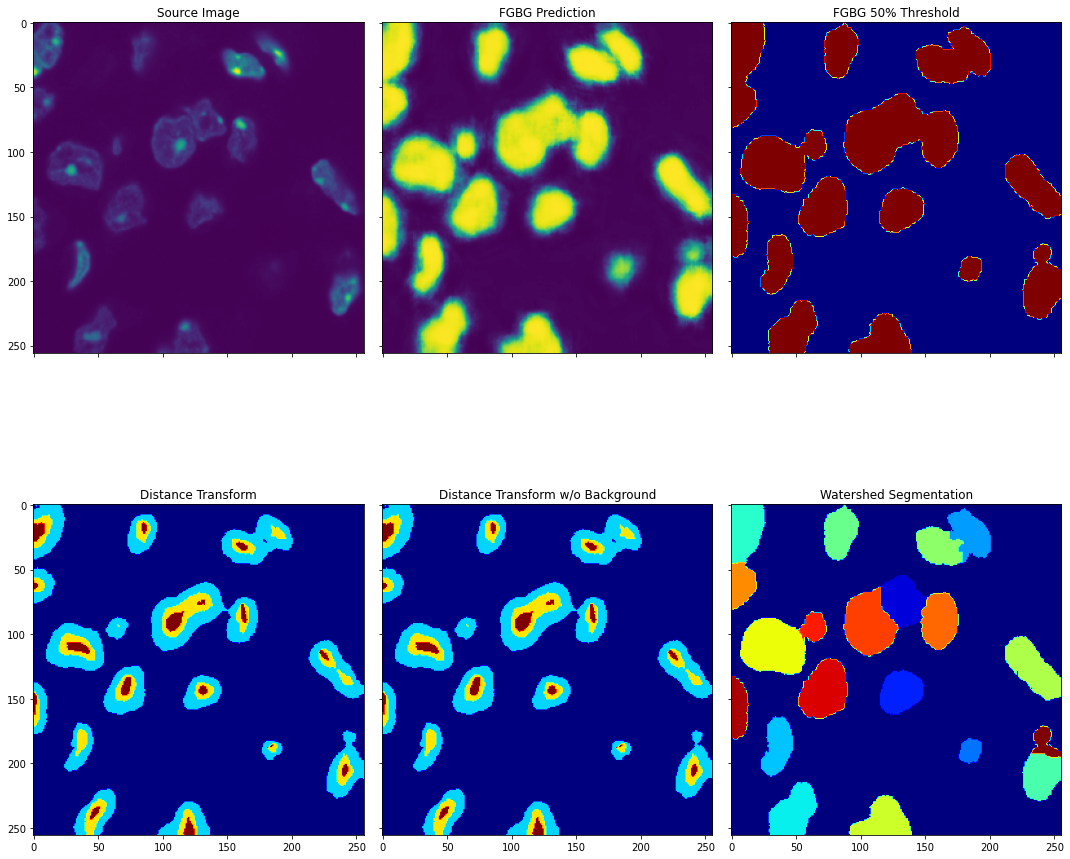

In [23]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

index = np.random.randint(low=0, high=watershed_images.shape[0])
frame = np.random.randint(low=0, high=watershed_images.shape[1])

print('Image:', index)
print('Frame:', frame)

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 15), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(X_test[index, frame, ..., 0])
ax[0].set_title('Source Image')

ax[1].imshow(test_images_fgbg[index, frame, ..., 1])
ax[1].set_title('FGBG Prediction')

ax[2].imshow(fg_thresh[index, frame, ..., 0], cmap='jet')
ax[2].set_title('FGBG {}% Threshold'.format(int(threshold * 100)))

ax[3].imshow(argmax_images[index, frame, ..., 0], cmap='jet')
ax[3].set_title('Distance Transform')

ax[4].imshow(argmax_images_post_fgbg[index, frame, ..., 0], cmap='jet')
ax[4].set_title('Distance Transform w/o Background')

ax[5].imshow(watershed_images[index, frame, ..., 0], cmap='jet')
ax[5].set_title('Watershed Segmentation')

fig.tight_layout()
plt.show()

In [24]:
# Can also export as a video
# But this does not render well on GitHub
from IPython.display import HTML
from deepcell.utils.plot_utils import get_js_video

HTML(get_js_video(watershed_images[..., [-1]], batch=index))